# Linear classifier in TensorFlow

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

`inputs` is `num_samples_per_class` negative samples followed by `num_samples_per_class` positive samples.

In [2]:
num_samples_per_class = 1000
def _samples(mean):
    return np.random.multivariate_normal(mean=mean, cov=[[1,.5],[.5,1]], size=num_samples_per_class)
inputs = np.vstack([_samples(mean) for mean in [[0,3], [3,0]]]).astype(np.float32)
targets = np.vstack([f([num_samples_per_class,1], dtype='float32') for f in [np.zeros, np.ones]])
inputs.shape, targets.shape

((2000, 2), (2000, 1))

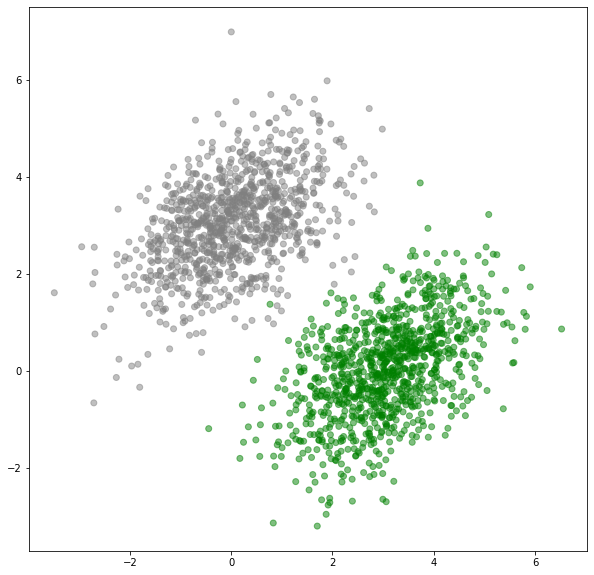

In [3]:
plt.rcParams["figure.figsize"] = (10, 10)
# target_colors = targets[:, 0]
target_colors = ['grey']*1000 + ['green']*1000 # grey for negative, green for positive
plt.scatter(inputs[:, 0], inputs[:, 1], c=target_colors, alpha=0.5)
plt.show()

In [4]:
class LinearModel:
    def __init__(self, input_dim=2, output_dim=1):
        self.input_dim, self.output_dim = input_dim, output_dim
        self.W = tf.Variable(tf.random.uniform([input_dim, output_dim]))
        self.b = tf.Variable(tf.zeros([output_dim,]))
    def __call__(self, inputs):
        return tf.matmul(inputs, self.W) + self.b
    @property
    def weights(self):
        return [self.W, self.b]
    def x_to_y(self, x):
        "Return `y` for a given `x` using the weights of this model"
        # W[0]*x + W[1]*y + b = 0.5
        # W[1]*y = 0.5 - b - W[0]*x
        return (0.5 - self.W[0]*x - self.b) / self.W[1]
        # y = ax+b
        # y = - self.W[0] / self.W[1] * x + (0.5  - self.b) / self.W[1]
    @property
    def slope(self):
        return - (self.W[0] / self.W[1])[0]
    @property
    def intercept(self):
        return ((0.5 - self.b) / self.W[1])[0]

In [5]:
def mse(y_true, y_pred):
    per_sample_losses = tf.square(y_true - y_pred)
    return tf.reduce_mean(per_sample_losses)

In [6]:
def training_step(model, inputs, targets, learning_rate):
    with tf.GradientTape() as tape:
        predictions = model(inputs)
        loss = mse(targets, predictions)
    gradients = tape.gradient(loss, model.weights)
    for learnable, gradient in zip(model.weights, gradients):
        learnable.assign_sub(gradient * learning_rate)
    return loss

&darr; 20 epochs will probably underfit ... this gives us a few misclassified examples to look at

In [7]:
def fit(model, inputs, targets, epochs=20, learning_rate=0.1):
    for epoch in range(epochs):
        loss = training_step(model, inputs, targets, learning_rate)
        print('epoch', epoch, 'loss', loss)

In [8]:
model = LinearModel()
fit(model, inputs, targets)

epoch 0 loss tf.Tensor(1.0853733, shape=(), dtype=float32)
epoch 1 loss tf.Tensor(0.1219928, shape=(), dtype=float32)
epoch 2 loss tf.Tensor(0.09355624, shape=(), dtype=float32)
epoch 3 loss tf.Tensor(0.08466718, shape=(), dtype=float32)
epoch 4 loss tf.Tensor(0.07925404, shape=(), dtype=float32)
epoch 5 loss tf.Tensor(0.07473339, shape=(), dtype=float32)
epoch 6 loss tf.Tensor(0.07065998, shape=(), dtype=float32)
epoch 7 loss tf.Tensor(0.06693666, shape=(), dtype=float32)
epoch 8 loss tf.Tensor(0.06352461, shape=(), dtype=float32)
epoch 9 loss tf.Tensor(0.0603964, shape=(), dtype=float32)
epoch 10 loss tf.Tensor(0.0575282, shape=(), dtype=float32)
epoch 11 loss tf.Tensor(0.05489833, shape=(), dtype=float32)
epoch 12 loss tf.Tensor(0.05248701, shape=(), dtype=float32)
epoch 13 loss tf.Tensor(0.050276075, shape=(), dtype=float32)
epoch 14 loss tf.Tensor(0.04824886, shape=(), dtype=float32)
epoch 15 loss tf.Tensor(0.046390094, shape=(), dtype=float32)
epoch 16 loss tf.Tensor(0.044685807,

Accuracy 0.9885
Ploting line for y = 2.30x + -2.56


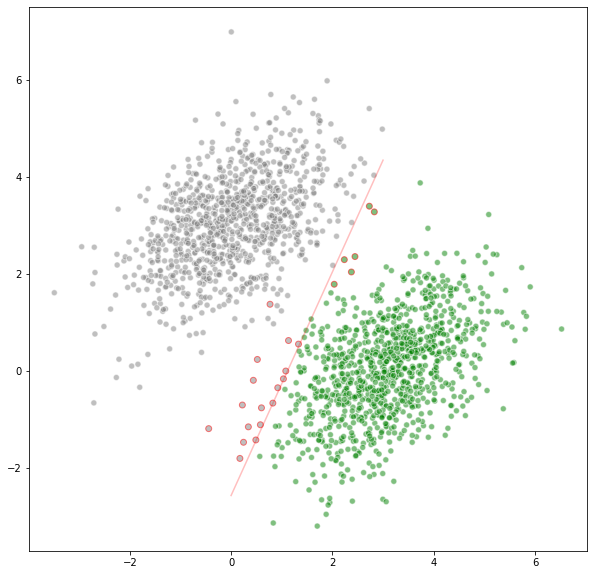

In [10]:
predictions = model(inputs)
correct_mask = tf.equal(*[tf.greater(t, 0.5) for t in [targets, predictions]])
print('Accuracy', tf.reduce_mean(tf.cast(correct_mask, tf.float32)).numpy())
prediction_colors = ['grey' if p < 0.5 else 'green' for p in predictions]
misclassified_colors = ['white' if correct else 'red' for correct in correct_mask]
plt.scatter(inputs[:, 0], inputs[:, 1], c=prediction_colors, edgecolors=misclassified_colors, alpha=0.5)
print(f'Ploting line for y = {model.slope:.2f}x + {model.intercept:.2f}')
x = np.linspace(0,3)
y = model.x_to_y(x)
plt.plot(x,y, 'r-', alpha=0.25)
plt.show()